In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import math

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [17]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


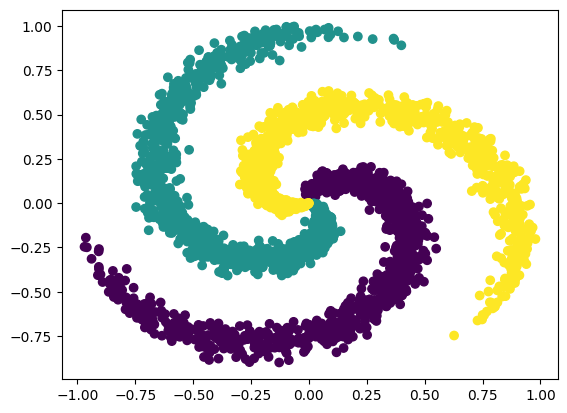

In [4]:
import matplotlib.pyplot as plt
X = X.cpu()
y = y.cpu()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [18]:
# X = X.to(device)
# y = y.to(device)
with device:
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, 100, shuffle=True, generator=torch.Generator(device))

In [ ]:
import torch
import torch.nn as nn
from lib.layers import Residual, Unpack
from lib.quantumsearch import FitnessFunction, OneToManyNetwork, QuantumSearch
from lib.quantumsearch import TransitionFunction
D = 2
H = 5
O = 3

encoder = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
)

search = QuantumSearch(
    transition=TransitionFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3*H),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., H, 3
            )
        ),
    ),
    fitness=FitnessFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., 1, 3
            )
        ),
    ),
    max_depth=3,
    beam_width=3,
    branching_width=3
)
model = nn.Sequential(encoder,Residual(search))
model.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (1): QuantumSearch(
    (transition): TransitionFunction(
      (one_to_many): OneToManyNetwork(
        (network): Sequential(
          (0): Linear(in_features=5, out_features=5, bias=True)
          (1): ReLU()
          (2): Linear(in_features=5, out_features=15, bias=True)
          (3): Unpack()
        )
      )
    )
    (fitness): FitnessFunction(
      (one_to_many): OneToManyNetwork(
        (network): Sequential(
          (0): Linear(in_features=5, out_features=5, bias=True)
          (1): ReLU()
          (2): Linear(in_features=5, out_features=3, bias=True)
          (3): Unpack()
        )
      )
    )
  )
)

In [20]:
def print_shape(name):
    def hook(module, input, output):
         print(f"{name} output shape: {output.shape}")
    return hook

In [21]:
encoder[1].register_forward_hook(print_shape("Encoder"))
search.transition.one_to_many.network[1].register_forward_hook(print_shape("Transition first linear Layer"))
search.transition.one_to_many.network[2].register_forward_hook(print_shape("Transition second linear Layer"))
search.transition.one_to_many.network[3].register_forward_hook(print_shape("Transition unpack  Layer"))
search.fitness.one_to_many.network[1].register_forward_hook(print_shape("fitness first 2d layer Layer"))  # After main transition Conv2d
search.fitness.one_to_many.network[2].register_forward_hook(print_shape("fitness second 2d layer Layer"))  # After main transition Conv2d
search.fitness.one_to_many.network[3].register_forward_hook(print_shape("fitness unpack layer Layer"))  # After main transition Conv2d

In [22]:
with device:
    sample_batch, _ = next(iter(data_loader))  # Get a batch from the dataloader
    sample_batch = sample_batch
    output = model(sample_batch)

Encoder output shape: torch.Size([100, 5])
max_d
Transition first linear Layer output shape: torch.Size([1, 100, 5])
Transition second linear Layer output shape: torch.Size([1, 100, 15])
Transition unpack  Layer output shape: torch.Size([1, 100, 5, 3])
candidates before flatten torch.Size([3, 1, 100, 5])
candidates torch.Size([3, 100, 5])
fitness first 2d layer Layer output shape: torch.Size([3, 100, 5])
fitness second 2d layer Layer output shape: torch.Size([3, 100, 3])
fitness unpack layer Layer output shape: torch.Size([3, 100, 1, 3])
after fitness torch.Size([3, 3, 100, 1])
fitness is working
candidates torch.Size([3, 100, 5]) candidates_fitness torch.Size([3, 3, 100, 1])
multi done
max_d
Transition first linear Layer output shape: torch.Size([3, 100, 5])
Transition second linear Layer output shape: torch.Size([3, 100, 15])
Transition unpack  Layer output shape: torch.Size([3, 100, 5, 3])
candidates before flatten torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
fitnes

In [5]:
from lib.layers import Residual, Unpack
from lib.quantumsearch import FitnessFunction, OneToManyNetwork, QuantumSearch
from lib.quantumsearch import TransitionFunction

D = 2
H = 5
O = 3

encoder = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
)

search = QuantumSearch(
    transition=TransitionFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3*H),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., H, 3
            )
        ),
    ),
    fitness=FitnessFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., 1, 3
            )
        ),
    ),
    max_depth=3,
    beam_width=3,
    branching_width=3
)

decoder = nn.Sequential(
    nn.Linear(H, 3)
)

model = nn.Sequential(
    encoder,
    Residual(search),
    decoder
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (1): Residual(
    (module): QuantumSearch(
      (transition): TransitionFunction(
        (one_to_many): OneToManyNetwork(
          (network): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=True)
            (1): ReLU()
            (2): Linear(in_features=5, out_features=15, bias=True)
            (3): Unpack()
          )
        )
      )
      (fitness): FitnessFunction(
        (one_to_many): OneToManyNetwork(
          (network): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=True)
            (1): ReLU()
            (2): Linear(in_features=5, out_features=3, bias=True)
            (3): Unpack()
          )
        )
      )
    )
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [6]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [7]:

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose
from torch.utils.data import TensorDataset, DataLoader

temperature = 3.0
gamma = 0.99
X = X.to(device)
y = y.to(device)
with device:
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, 100, shuffle=True, generator=torch.Generator(device))

    # Training
    for t in range(100):

        for batch, targets in data_loader:

            # Feed forward to get the logits
            y_pred = model(batch)


            # loss
            loss = criterion(y_pred, targets)

            # accuracy
            score, predicted = torch.max(y_pred, 1)
            acc = (targets == predicted).sum().float() / len(targets)

            print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
            # display.clear_output(wait=False)

            # zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # Backward pass to compute the gradient
            # of loss w.r.t our learnable params.
            loss.backward()

            # clip gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)

            # Update params
            optimizer.step()

insisde transittion torch.Size([3, 1, 100, 5])
candidates torch.Size([3, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
torch.Size([100, 3])
[EPOCH]: 0, [LOSS]: 1.127279, [ACCURACY]: 0.340
insisde transittion torch.Size([3, 1, 100, 5])
candidates torch.Size([3, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
torch.Size([100, 3])
[EPOCH]: 0, [LOSS]: 1.110470, [ACCURACY]: 0.340
insisde transittion torch.Size([3, 1, 100, 5])
candidates torch.Size([3, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
insisde transittion torch.Size([3, 3, 100, 5])
candidates torch.Size([9, 100, 5])
torch.Size([100, 3])
[EPOCH]: 0, [LOSS]: 1.108232, [ACCURACY]: 0.440
insisde transittion torch.Size([3, 1, 100, 5])
candidat

KeyboardInterrupt: 